## RQ2

What are the time slots with more passengers? Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them.

In [1]:
''' imports '''
import pandas as pd
import numpy as np
from loader import Loader
import matplotlib.pyplot as plt
%matplotlib inline

''' data paths '''
data = {
    'jan': {
        'path': 'data/yellow_tripdata_2018-01.csv',
        'start': '2018-01-01',
        'end': '2018-01-31'
    },
    'feb': {
        'path': 'data/yellow_tripdata_2018-02.csv',
        'start': '2018-02-01',
        'end': '2018-02-28'
    },
    'mar': {
        'path': 'data/yellow_tripdata_2018-03.csv',
        'start': '2018-03-01',
        'end': '2018-03-31'
    },
    'apr': {
        'path': 'data/yellow_tripdata_2018-04.csv',
        'start': '2018-04-01',
        'end': '2018-04-30'
    },
    'may': {
        'path': 'data/yellow_tripdata_2018-05.csv',
        'start': '2018-05-01',
        'end': '2018-05-31'
    },
    'jun': {
        'path': 'data/yellow_tripdata_2018-06.csv',
        'start': '2018-06-01',
        'end': '2018-06-30'
    }
}
locations = 'data/taxi_zone_lookup.csv'

# make it dynamic
# MONTH = data['jan']
MONTHS = [(m, data[m]['path']) for m in data.keys()]

Let's use a Loader class, created ad hoc, to simplify some operations

In [2]:
# read data for each month
# todo: combine all months together
loader = Loader(csv=MONTHS, chunksize=100000)

# preparing locations to be merged on-the-fly when iterating
loader.merge(csv=locations, usecols=['LocationID', 'Borough'], on=('PULocationID', 'LocationID'), direction='left', drop_on_columns=True)

# get data generator
data_iterator = loader.iterate(usecols=['tpep_pickup_datetime', 'passenger_count', 'PULocationID'], parse_dates=['tpep_pickup_datetime'], date_index='tpep_pickup_datetime')

In [3]:
# defining hourly time slots (overall)
h_slots = {str(x % 24) + ':00 ' + str(x % 24) + ':59': 0 for x in range(24)}

# here the borough's stats will be put
h_slots_borough = {}

print(h_slots)

{'0:00 0:59': 0, '1:00 1:59': 0, '2:00 2:59': 0, '3:00 3:59': 0, '4:00 4:59': 0, '5:00 5:59': 0, '6:00 6:59': 0, '7:00 7:59': 0, '8:00 8:59': 0, '9:00 9:59': 0, '10:00 10:59': 0, '11:00 11:59': 0, '12:00 12:59': 0, '13:00 13:59': 0, '14:00 14:59': 0, '15:00 15:59': 0, '16:00 16:59': 0, '17:00 17:59': 0, '18:00 18:59': 0, '19:00 19:59': 0, '20:00 20:59': 0, '21:00 21:59': 0, '22:00 22:59': 0, '23:00 23:59': 0}


In [4]:
''' working with each borough '''
# declaring two counters to enhance verbosity
tot_rows = 0
processed_rows = 0

# iterate over chunks
for month, d in data_iterator:
    
    # info
    tot_rows += len(d.index)
    
    # remove older or newer items keeping only the ones
    # strictly related to the considered month
    d = d.loc[data[month]['start'] : data[month]['end']]
    
    # drop any row with missing values
    d = d.dropna()
    
    # processing each time span (slot)
    for time_span, count in h_slots.items():
        h_start, h_end = time_span.split(' ')
        
        # filter DataFrame by time span
        f = d.between_time(h_start, h_end)
        
        # info
        processed_rows += len(f.index)
        
        # compute and save the sum for this chunk
        h_slots[time_span] += f['passenger_count'].sum()
        
        # borough based sum()
        f_grouped = f.groupby('Borough')['passenger_count'].count()
        
        # save count for each Borough
        for borough in f_grouped.keys():
            p_count = f_grouped[borough]
            
            if not borough in h_slots_borough:
                h_slots_borough[borough] = p_count
            else:
                h_slots_borough[borough] += p_count

print(str(processed_rows) + ' over ' + str(tot_rows) + ' rows have been processed')

53049017 over 53925735 rows have been processed


In [5]:
print(h_slots)
print(h_slots_borough)

{'0:00 0:59': 2692896, '1:00 1:59': 1853823, '2:00 2:59': 1326429, '3:00 3:59': 968774, '4:00 4:59': 763653, '5:00 5:59': 798483, '6:00 6:59': 1817041, '7:00 7:59': 3098468, '8:00 8:59': 3871652, '9:00 9:59': 3911072, '10:00 10:59': 3899741, '11:00 11:59': 4073599, '12:00 12:59': 4336652, '13:00 13:59': 4373976, '14:00 14:59': 4592950, '15:00 15:59': 4589373, '16:00 16:59': 4278131, '17:00 17:59': 4865151, '18:00 18:59': 5470188, '19:00 19:59': 5292108, '20:00 20:59': 4787224, '21:00 21:59': 4852798, '22:00 22:59': 4603556, '23:00 23:59': 3751354}
{'Bronx': 54789, 'Brooklyn': 671655, 'Manhattan': 48165475, 'Queens': 3302453, 'Unknown': 850044, 'Staten Island': 801, 'EWR': 3800}


In [5]:
print(sorted(h_slots.items(), reverse=True, key=lambda kv: kv[1]))

[('18:00 18:59', 5470188), ('19:00 19:59', 5292108), ('17:00 17:59', 4865151), ('21:00 21:59', 4852798), ('20:00 20:59', 4787224), ('22:00 22:59', 4603556), ('14:00 14:59', 4592950), ('15:00 15:59', 4589373), ('13:00 13:59', 4373976), ('12:00 12:59', 4336652), ('16:00 16:59', 4278131), ('11:00 11:59', 4073599), ('9:00 9:59', 3911072), ('10:00 10:59', 3899741), ('8:00 8:59', 3871652), ('23:00 23:59', 3751354), ('7:00 7:59', 3098468), ('0:00 0:59', 2692896), ('1:00 1:59', 1853823), ('6:00 6:59', 1817041), ('2:00 2:59', 1326429), ('3:00 3:59', 968774), ('5:00 5:59', 798483), ('4:00 4:59', 763653)]


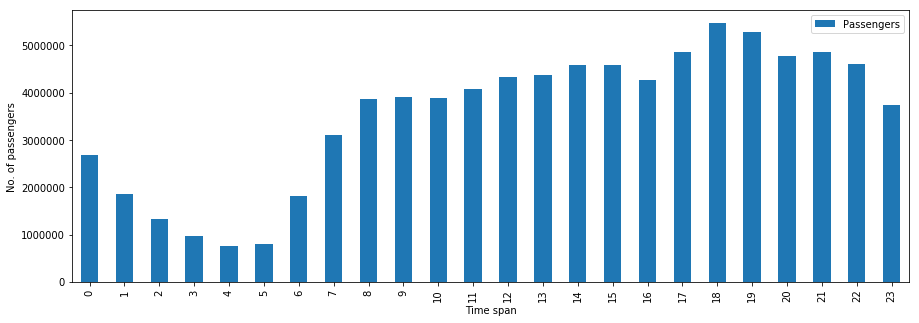

In [6]:
# create a DataFrame to easily be plotted
df = pd.DataFrame(list(h_slots.items()), columns=['HHSlots', 'Passengers'], index=list(range(24)))

# plotting...
figure, axes = plt.subplots(figsize=(15,5))
axes.set(xlabel='Time span', ylabel='No. of passengers')

# fill the axes X with the right names
df.plot.bar(ax=axes)

In [ ]:
# todo: bar chart to show each borough